# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:
#       student details: Dvir B. 7853

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The project uses the Titanic dataset to address a binary classification problem: predicting passenger survival (0 = not survived, 1 = survived). The dataset includes demographic and travel-related features such as class, sex, age, fare, and boarding point. The target variable is Survived, and model performance will be evaluated using the F1 score.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier



In [31]:
# Load Titanic train and test datasets
train = pd.read_csv("titanic_train.csv")
test  = pd.read_csv("titanic_test.csv")

# Show first 5 rows of each dataset
print("\n--- Train head ---")
display(train.head())

print("\n--- Test head ---")
display(test.head())



--- Train head ---


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0



--- Test head ---


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


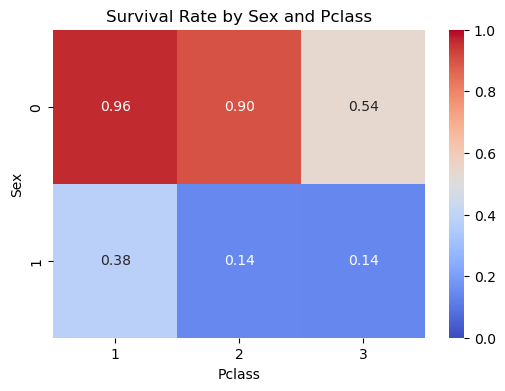

In [33]:


rate_tbl = (train
            .groupby(["Sex", "Pclass"])["Survived"]
            .mean()
            .reset_index())

# הופכים לפיבוט כדי לצייר Heatmap יפה
pivot_rate = rate_tbl.pivot(index="Sex", columns="Pclass", values="Survived")

plt.figure(figsize=(6,4))
sns.heatmap(pivot_rate, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="coolwarm")
plt.title("Survival Rate by Sex and Pclass")
plt.ylabel("Sex"); plt.xlabel("Pclass")
plt.show()


In [35]:
#This heatmap shows survival rates for different groups of passengers based on their gender and travel class
#The numbers represent the proportion of survivors in each group, and the colors highlight high (red) or low (blue) survival rates.
#We can see that men in higher classes had much higher chances of survival compared to men in lower classes,
#while women had generally lower survival rates across all classes.
#the idea was to test the connection between the gender and class to the chances of survivel.

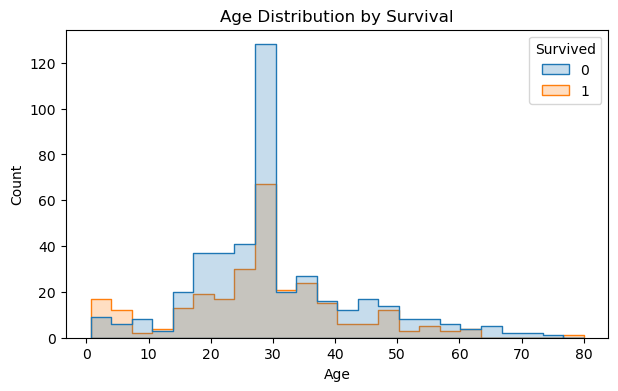

In [37]:


age_known = train.dropna(subset=["Age"]).copy()

plt.figure(figsize=(7,4))
sns.histplot(data=age_known, x="Age", hue="Survived", bins=24, kde=False, element="step", stat="count")
plt.title("Age Distribution by Survival")
plt.xlabel("Age"); plt.ylabel("Count")
plt.show()

In [39]:
#This histogram shows the distribution of passenger ages, split by whether they survived or not.
#Younger passengers, especially children under 10, had  higher survival rates.
#In contrast, most adults had lower survival chances, with many more non-survivors in the age range of 20 to 40.
#This suggests that age played an important role in survival outcomes.

## Part 3 - Experiments
You could add as many code cells as needed

In [42]:


target_col   = "Survived"
num_features = ["Age", "Fare", "SibSp", "Parch"]
cat_features = ["Pclass", "Sex", "Embarked"]

X_train = train[num_features + cat_features].copy()
y_train = train[target_col].copy()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)


In [44]:
# Pipeline: preprocessing -> KNN
pipe_knn = Pipeline(steps=[
    ("prep", preprocess),
    ("model", KNeighborsClassifier())
])

# גריד סביר ל-Titanic (לא כבד מדי)
param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11],
    "model__weights": ["uniform", "distance"],
    # Minkowski עם p=2 הוא Euclidean, p=1 הוא Manhattan — נבדוק שניהם
    "model__p": [1, 2],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),  # מדד ההערכה: F1 (Binary)
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Best F1 (CV mean):", grid.best_score_)
print("Best params:", grid.best_params_)


Best F1 (CV mean): 0.7303143363394649
Best params: {'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'uniform'}


In [45]:
cvres = pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)
cols_to_show = [
    "mean_test_score", "std_test_score", "mean_train_score",
    "param_model__n_neighbors", "param_model__weights", "param_model__p"
]
cvres[cols_to_show].head(15)


,mean_test_score,std_test_score,mean_train_score,param_model__n_neighbors,param_model__weights,param_model__p
12,0.730314,0.019090,0.772682,9,uniform,1
13,0.720598,0.046892,0.979256,9,distance,1
16,0.719290,0.025933,0.762612,11,uniform,1
18,0.716791,0.032672,0.763839,11,uniform,2
17,0.713421,0.045608,0.979256,11,distance,1
14,0.711061,0.032398,0.763333,9,uniform,2
9,0.708010,0.045530,0.979256,7,distance,1
4,0.707844,0.039846,0.799330,5,uniform,1
6,0.706618,0.052547,0.794189,5,uniform,2
5,0.706042,0.040831,0.979256,5,distance,1


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [49]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
best_model


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', KNeighborsClassifier(n_neighbors=9, p=1))])

## Part 5 - Apply on test and show model performance estimation

Test F1: 0.7377049180327869

Classification report:
               precision    recall  f1-score   support

           0      0.864     0.864     0.864       118
           1      0.738     0.738     0.738        61

    accuracy                          0.821       179
   macro avg      0.801     0.801     0.801       179
weighted avg      0.821     0.821     0.821       179



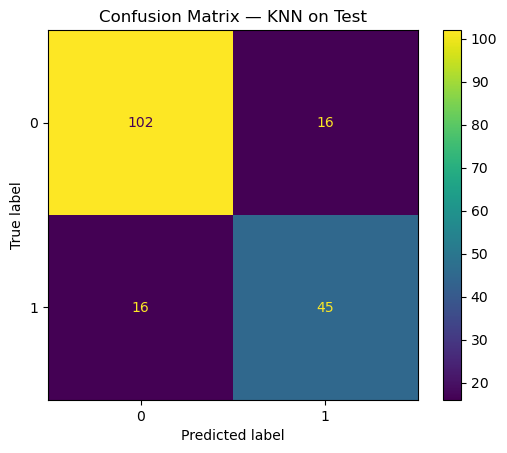

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,1
4,1,1
5,1,1
6,0,1
7,0,0
8,1,1
9,0,0


In [53]:
X_test = test[num_features + cat_features].copy()
y_test = test[target_col].copy()

y_pred = best_model.predict(X_test)

# F1 סופי על test
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("Test F1:", f1)

# דוח קצר (Precision/Recall/F1 לכל מחלקה)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# מטריצת בלבול
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — KNN on Test")
plt.show()

# הצגה של 10 חיזויים ראשונים מול אמת (לא חובה, נחמד להדגים)
pd.DataFrame({"y_true": y_test.values[:10], "y_pred": y_pred[:10]})